In [1]:
import os
os.environ["OMP_NUM_THREADS"]='1'
import osmnx as ox
import networkx as nx

import pandas as pd
import geopandas as gpd

from pyproj import Transformer 
import numpy as np
import scipy
from descartes import PolygonPatch

import matplotlib.pyplot as plt
from matplotlib import *
from matplotlib.patches import *
from matplotlib.lines import Line2D

import contextily as cx #Copyright (c) 2016, Dani Arribas-Bel. All rights reserved.

import math
import itertools
from shapely.geometry import MultiPolygon, Polygon, Point, LineString
from IPython.display import Image, IFrame

from sklearn import cluster
from sklearn.cluster import KMeans


import pandapower as pp
from pandapower.plotting import simple_plot, simple_plotly, pf_res_plotly 


# 1. Daten sammeln und aufbereiten

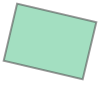

In [2]:
#Polygon als GeoDataFrame
polygon = gpd.read_file(r".\Daten\Test")
#Polygon als Polygon-Objekt
new_poly = polygon["geometry"].iloc[0]
new_poly

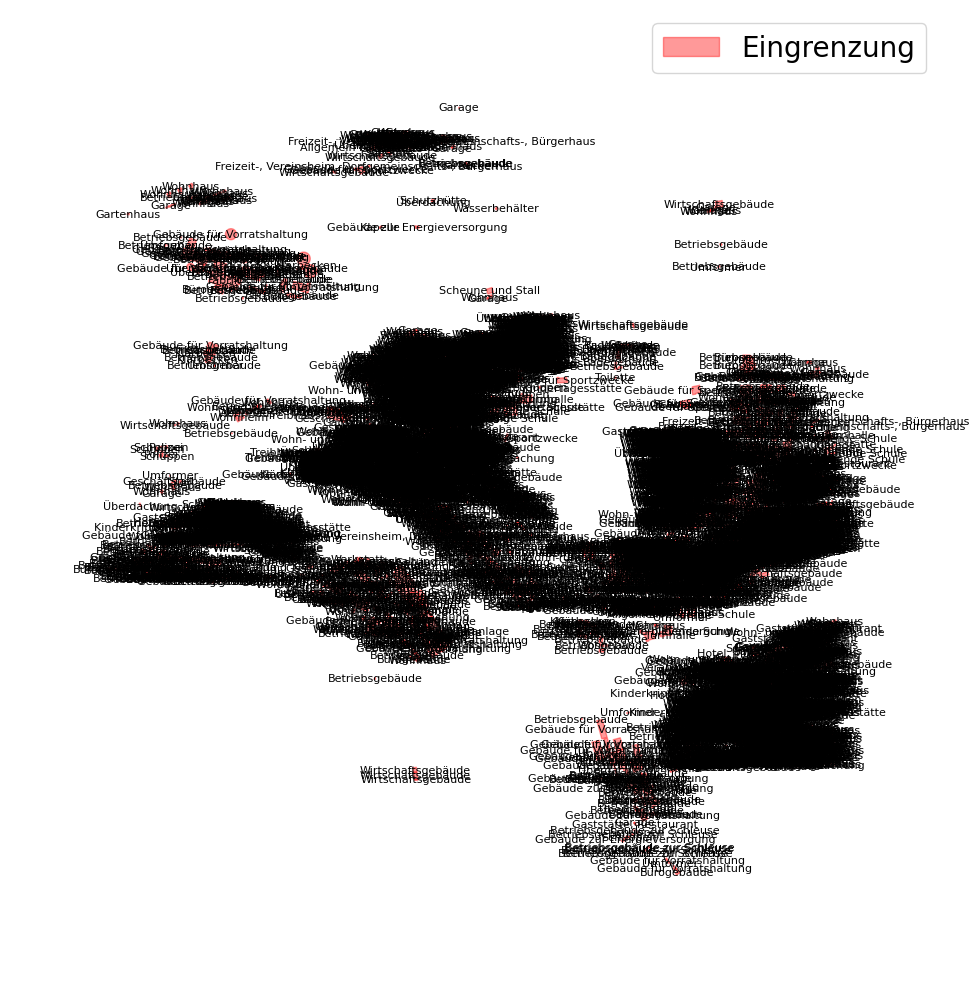

In [9]:
# PLOT DER EINGRENZUNG

#Konvertierung in metrisches System
poly_draw = polygon.to_crs(epsg=25832)
# geometrische Form des Polygons
polygon_geometry = poly_draw.unary_union
#Min & Max x,y werte des Polygons
min_x, min_y, max_x, max_y = polygon_geometry.bounds

zoom_factor = 500
#neue Eingrenzungen des Plots
new_min_x = min_x-zoom_factor
new_max_x = max_x+zoom_factor
new_min_y = min_y-zoom_factor
new_max_y = max_y+zoom_factor

fig, ax=plt.subplots(1, figsize=(12,15))
poly_draw.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.4)

ax.set_axis_off()

ax.set_xlim(new_min_x, new_max_x)
ax.set_ylim(new_min_y, new_max_y)

legend_elements= [Patch(edgecolor='red', facecolor='red', alpha =0.4, label='Eingrenzung')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=20)
#print(poly_draw)
for x, y, label in zip(poly_draw.geometry.centroid.x, poly_draw.geometry.centroid.y, poly_draw['funktion']):
    ax.text(x, y, label, fontsize=8, ha='center', va='center')
#cx.add_basemap(ax=ax, crs=poly_draw.crs)


#plt.savefig(r'H:\Studium\7_Semester\BA\BA Schreiben\Bilder\eingrenzung_ind.svg', format='svg', bbox_inches='tight')

plt.show()

In [10]:
def getBuildingTypes(buildings_Data):
    all_building_types = []
    building_types = []
    for i in range(len(buildings_Data)):
        all_building_types.append(buildings_Data.funktion.iloc[i])
    building_types = set(all_building_types)
    return building_types


In [12]:
building_types = getBuildingTypes(poly_draw)
print(building_types)
print(len(building_types))

{'Friedhofsgebäude', 'Gemeindehaus', 'Geschäftsgebäude', 'Toilette', 'Polizei', 'Gartenhaus', 'Schuppen', 'Post', 'Seniorenheim', 'Freizeit-, Vereinsheim, Dorfgemeinschafts-, Bürgerhaus', 'Sport-, Turnhalle', 'Silo', 'Betriebsgebäude', 'Scheune', 'Schutzhütte', 'Rathaus', 'Gaststätte, Restaurant', 'Tank', 'Kinderkrippe, Kindergarten, Kindertagesstätte', 'Treibhaus, Gewächshaus', 'Wohnhaus', 'Umformer', 'Gebäude für Vorratshaltung', 'Kirchturm, Glockenturm', 'Veranstaltungsgebäude', None, 'Freizeit- und Vergnügungsstätte', 'Verwaltungsgebäude', 'Wasserbehälter', 'Tankstelle', 'Überdachung', 'Wirtschaftsgebäude', 'Garage', 'Kirche', 'Kapelle', 'Wohn- und Betriebsgebäude', 'Allgemein bildende Schule', 'Feuerwehr', 'Wohn- und Geschäftsgebäude', 'Hotel, Motel, Pension', 'Gebäude zur Energieversorgung', 'Scheune und Stall', 'Fabrik', 'Werkstatt', 'Wohnheim', 'Gebäude für Sportzwecke', 'Badegebäude', 'Wohn- und Bürogebäude', 'Tiefgarage', 'Klärbecken', 'Bürogebäude', 'Schornstein', 'Betriebsg

# 1.1 Gebäude erfassen und Datensatz Filtern

In [4]:
#alle Gebäude innerhalb des Polygons erfassen
buildings = ox.features.features_from_polygon(new_poly, tags={"building":True})

#Auf wichtigste Columns beschränken:
buildings = buildings.filter(['geometry', 'nodes', 'building','building:levels','power', 'ways', axis=='columns'])

#Alle NaN Stockwerkwerte mit 1 ersetzen:
buildings[['building:levels']] = buildings[['building:levels']].fillna(int(1))

RuntimeError: Unable to determine UTM CRS

In [ ]:
#Gebäudezentren bestimmen
#buildings = buildings.to_crs(epsg=4326)
centroid_calc = buildings.to_crs(epsg=25832)#4326
centroids = centroid_calc.centroid
lons = list(centroids.x)
lats = list(centroids.y)

building_coords = [[lons[i],lats[i]] for i in range(len(lons))]
buildings = buildings.to_crs(epsg=25832)
#print(building_coords)

In [ ]:
#Straßengraph mit oder ohne custom_filter erstellen
cf = '["highway"~"unclassified|residential|secondary|secondary_link|tertiary|tertiary_link|turning_circle|turning_loop"]'
streets_graph_poly = ox.graph_from_polygon(new_poly, simplify=False, retain_all=True, truncate_by_edge=False)
streets_graph_poly = ox.project_graph(streets_graph_poly, to_crs=25832)
#fig, ax = ox.plot_graph(streets_graph_poly, node_size=5, bgcolor='w', node_color='k')

In [ ]:
nodes= ox.graph_to_gdfs(streets_graph_poly, nodes=True, edges=False)
edges= ox.graph_to_gdfs(streets_graph_poly, edges=True, nodes=False)
#nodes.plot()
#edges.plot()


In [ ]:
#PLOT DER GEBÄUDE UND STRAßENGRAPHEN

fig, ax=plt.subplots(1, figsize=(13,11))
ax.set_axis_off()
ax.set_aspect('equal')
poly_draw.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.1)
#Gebäude
buildings.plot(ax=ax, alpha=0.7, color='black')
#Legende
legend_elements = [
    Patch(color='red', alpha =0.1, label='Eingrenzung'),
    Patch(color='black', alpha =0.7, label='Gebäudeumrisse'),
    Line2D([0], [0], marker='o', color='green', markersize=10, label='Straßengraph', linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=17)
#Straßengraph

ox.plot_graph(streets_graph_poly, ax=ax, node_size=10, edge_color="green", node_color="green", edge_linewidth=0.7, save=False, filepath=r'H:\Studium\7_Semester\BA\BA Schreiben\Bilder\buildings_and_g.svg')
plt.show()

# Flächeninhalt

In [ ]:
#Flächeninhalt der Gebäude
buildings_poly = buildings['geometry']
#Transformation der Coordinaten in x,y Werten zur Flächenberechnung
buildings_poly_m = buildings_poly.to_crs(25832)
#Speichern der Flächen in Übergangsarray
buildings_area=[]
for i in range(len(buildings_poly_m)):
    buildings_area.append(buildings_poly_m[i].area)
    #print(buildings_area[i])
    
#Hinzufügen der berechneten Flächen zum GeoDataFrame (buildings)
buildings.insert(loc=0, column='flaeche', value=buildings_area)
#buildings

# Lastzuweisung

In [ ]:
#Power zu allen beschriebenen Gebäudetypen zuweisen:
#OFFICES     : Wert aus VerbrauchPDF                       : 0.00685  kW/m2
#INDUSTRIALS : Wert aus DaVe                               : 0.01     kW/m2
#COMMERCIALS : Wert aus DaVe                               : 0.003    kW/m2 
#WAREHOUSES  : Wert aus DaVe                               : 0.003    kW/m2
#HOTELS      : Wert aus VerbrauchPDF, 12h pro Tag(Annahme) : 0.0514   kW/m2
#RESIDENTIALS: Wert aus DaVe                               : 0.002    kW/m2
#APARTMENTS  : Wert aus DaVe                               : 0.002    kW/m2
#RETAIL(1)   : Wert aus VerbrauchPDF                       : 0.0106   kW/m2
    #(1) Durschnittsverbrauch (Lebensmittel und Nicht-Lebensmittel Einzelhandel) : 92,78 kWh/m2a
#YES(Annahme): Wert aus DaVe (Bezogen auf Fläche unterschiedliche Werte) : 0.003 - 0.01 kW/m2

def addPower(buildings_Data): 
    buildings_power = []
    for i in range(len(buildings_Data)):
        b = buildings_Data.building.iloc[i]
        level = int(buildings_Data['building:levels'].iloc[i])
        if b == 'office':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0.00685)
            
        elif b == 'industrial':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0.01)
            
        elif b == 'commercial':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level *0.003)
            
        elif b == 'warehouse':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0.003)
            
        elif b == 'hotel':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0.0514)
        
        elif b == 'residential':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0.002)
            
        elif b == 'apartments':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0.002)
        
        elif b == 'retail':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0.0106)
            
        elif b == 'kiosk':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0.0106)

        elif b == 'yes' or b == 'barn' or b == 'farm_auxiliary' or b == 'house' or b == 'detached' or b == 'service':
            #14277m^2 größtes; 5,7m^2 kleinstes (bei yes_buildings)# Durchschnittsfläche:1095.26m^2
            if buildings_Data.flaeche.iloc[i] <5000:
                buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0.00685)
            elif 5000 < buildings_Data.flaeche.iloc[i] < 10000:
                buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0.01)
            elif buildings_Data.flaeche.iloc[i] >10000:
                buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0.003)

        elif b == 'roof':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0)
        elif b == 'parking':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0)
        elif b == 'carport':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0)
            
        
        else: raise ValueError(f"Gebäudelast für den Gebäudetyp {buildings_Data.building.iloc[i]} nicht Definiert")
    
    buildings_Data.insert(loc=1, column='last_kW', value=buildings_power)
    return buildings_Data

In [ ]:
# gibt die Summierte Last von einem Gebäudetyp an
def getSumPower(buildings):
    summ = 0
    for i in range(len(buildings)):
        summ += buildings.last_kW.iloc[i]
    return summ

In [ ]:
#for i in range(len(yes_buildings)):
#    if yes_buildings.flaeche.iloc[i] > 5000:
#        print(yes_buildings.iloc[i])

In [ ]:
buildings = addPower(buildings)

In [ ]:
buildings_power = getSumPower(buildings)
buildings_power

In [ ]:
#Herausfinden welches Gebäude die höchste / zweit höchste / etc Last besitzt
for i in range(len(buildings)):
    if buildings.last_kW.iloc[i]==buildings['last_kW'].nlargest(2).iloc[-1]:
        print(buildings.iloc[i])

In [ ]:
#Plot der heatmap gebäude
fig, ax = plt.subplots(figsize=(10, 10))
cmap = "viridis"
# Heatmap mit GeoDataFrame und last_kW als Farbzuweisung
buildings.plot(ax=ax, column="last_kW", cmap=cmap, legend=False)

# Farblegende hinzufügen
cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='vertical', fraction=0.04, pad=0.01)
cbar.set_label("Gebäudelast in kW",fontsize=12)
ax.set_axis_off()

#plt.savefig(r'H:\Studium\7_Semester\BA\BA Schreiben\Bilder\heatmap.svg', format='svg', bbox_inches='tight')
plt.show()
print(buildings)

# Erzeugung von MaStR einbeziehen


In [ ]:
def read_csv_select_columns(file_path, selected_columns):
# CSV Datei einlesen und nur Zeilen mit Koordinaten behalten
    try:
        # Daten aus CSV-Datei einlesen
        data = pd.read_csv(file_path,sep=";", decimal = ',')

        selected_data = data[selected_columns]

        # Nur ausgewählte Spalten behalten
        if 'Koordinate: Breitengrad (WGS84)' in selected_columns and 'Koordinate: Breitengrad (WGS84)' in data.columns:
            selected_data = selected_data[selected_data['Koordinate: Breitengrad (WGS84)'].notnull()]
        
        # Koordinaten zu geometry hinzufügen
        geometry = [Point(xy) for xy in zip ( selected_data['Koordinate: Längengrad (WGS84)'], selected_data['Koordinate: Breitengrad (WGS84)'])]
        gdf =  gpd.GeoDataFrame(selected_data, geometry=geometry)
        return gdf
    except Exception as e:
        print("Fehler beim Einlesen der CSV-Datei:", e)

In [ ]:
# Daten von MaStR einlesen
file_path   = r".\Daten\Stromerzeuger.csv"
selected_columns = ['Nettonennleistung der Einheit','Koordinate: Breitengrad (WGS84)','Koordinate: Längengrad (WGS84)','Volleinspeisung oder Teileinspeisung','Spannungsebene']

PV_Anlagen = read_csv_select_columns(file_path,selected_columns)

# In passendes Koordinatensystem umwandeln
PV_Anlagen.crs = "EPSG:4326"
PV_Anlagen = PV_Anlagen.to_crs(epsg=25832)
# Koordinaten auf Polygon beschränken
PV_Anlagen_gefiltert = PV_Anlagen[PV_Anlagen.within(polygon_geometry)]

In [ ]:
def nearest_polygon(point, polygons):
    nearest_geom = None
    min_distance = float('inf')
    for polygon in polygons:
        distance = point.distance(polygon)  # Berechnung des Abstands
        if distance < min_distance:
            nearest_geom = polygon
            min_distance = distance
    return nearest_geom, min_distance

In [ ]:
def assign_points_to_buildings(buildings_gdf, points_gdf):
    """
    Weist Punkte den Gebäuden in einem GeodataFrame zu und fügt neue Spalten für
    Erzeugungsleistung und Netzanschluss zu den Gebäuden hinzu.

    Parameters:
        buildings_gdf (geopandas.GeoDataFrame): GeodataFrame mit Gebäuden.
        points_gdf (geopandas.GeoDataFrame): GeodataFrame mit Punkten, die den Gebäuden zugeordnet werden sollen.

    Returns:
        geopandas.GeoDataFrame: GeodataFrame mit den zugeordneten Punkten und den neuen Spalten für Erzeugungsleistung und Netzanschluss.
    """
    # Setze das Koordinatenbezugssystem auf EPSG 25832
    buildings_gdf = buildings_gdf.to_crs(epsg=25832)
    points_gdf = points_gdf.to_crs(epsg=25832)

    # Erzeuge neue Spalten für Erzeugungsleistung und Netzanschluss in buildings_gdf
    buildings_gdf['Erzeugungsleistung'] = 0.0  # Standardwert für Gebäude ohne zugeordnete Punkte
    buildings_gdf['Netzanschluss'] = ''     # Standardwert für Gebäude ohne zugeordnete Punkte

    # Gehe durch jede PV-Anlage
    for index, point in points_gdf.iterrows():
        found_building = False
        # Überprüfe, in welchem Gebäude der Punkt liegt
        for index, building in buildings_gdf.iterrows():
            if point.geometry.within(building.geometry):
                # Füge die Erzeugungsleistung der Anlage dem Gebäude hinzu
                buildings_gdf.at[index, 'Erzeugungsleistung'] += point['Nettonennleistung der Einheit']
                # Füge den Netzanschluss der Anlage dem Gebäude hinzu
                buildings_gdf.at[index, 'Netzanschluss'] += point['Spannungsebene'] + ','
                found_building = True
                break  # Beende die Schleife, wenn das Gebäude gefunden wurde
        
        # Wenn punkt nicht direkt in einem gebäude liegt wird er dem nächsten Gebäude zugeordnet
        if not found_building:
            nearest_poly, min_distance = nearest_polygon(point.geometry, buildings_gdf.geometry)
            for index, building in buildings_gdf.iterrows():
                if building.geometry.equals(nearest_poly):
                    # Füge die Erzeugungsleistung der Anlage dem Gebäude hinzu
                    buildings_gdf.at[index, 'Erzeugungsleistung'] += point['Nettonennleistung der Einheit']
                    # Füge den Netzanschluss der Anlage dem Gebäude hinzu
                    buildings_gdf.at[index, 'Netzanschluss'] += point['Spannungsebene'] + ','
                    break
        #print(buildings.Netzanschluss)    
    return buildings_gdf

In [ ]:
# PV-Anlagen zu den Gebäuden hinzufügen
buildings = assign_points_to_buildings(buildings, PV_Anlagen_gefiltert)

#Plot der heatmap gebäude
fig, ax = plt.subplots(figsize=(10, 10))
cmap = "viridis"

# Heatmap mit GeoDataFrame und Erzeugungsleistung als Farbzuweisung
buildings.plot(ax=ax, column="Erzeugungsleistung", cmap=cmap, legend=False,alpha=0.5)
PV_Anlagen_gefiltert.plot(ax=ax, column="Nettonennleistung der Einheit", cmap=cmap, legend=False)

# Farblegende hinzufügen
cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='vertical', fraction=0.04, pad=0.01)
cbar.set_label("Erzeugungsleistung in kW",fontsize=12)
ax.set_axis_off()

#plt.savefig(r'H:\Studium\7_Semester\BA\BA Schreiben\Bilder\heatmap.svg', format='svg', bbox_inches='tight')
plt.show()


In [ ]:
power = ox.features.features_from_polygon(new_poly, tags={"power":True})
power.crs = "EPSG:4326"
power = power.to_crs(epsg=25832)
#print(power.power)
#for i in range(len(power.power)):
#    p = power.power.iloc[i]
#    if p == "transformer":
#        print(power.iloc[i])

fig, ax = plt.subplots(figsize=(10, 10))

# Heatmap mit GeoDataFrame und Erzeugungsleistung als Farbzuweisung
buildings.plot(ax=ax, legend=False,alpha=0.5)
power.plot(ax=ax, column = "power",legend=True)
ax.set_axis_off()

#plt.savefig(r'H:\Studium\7_Semester\BA\BA Schreiben\Bilder\heatmap.svg', format='svg', bbox_inches='tight')
plt.show()

# Gebäude in Gruppen trennen

In [ ]:
#Alle hier beinhaltete "building Tags"
def getBuildingTypes(buildings_Data):
    all_building_types = []
    building_types = []
    for i in range(len(buildings_Data)):
        all_building_types.append(buildings_Data.building.iloc[i])
    building_types = set(all_building_types)
    return building_types        
#yes, retail, office, warehouse, commercial, industrial, roof, detached, hotel, 
#parking, apartments, residential, farm_auxiliary, barn, house, carport, service

In [ ]:
building_types = getBuildingTypes(buildings)
#building_types

In [ ]:
#Anzahl der Gebäude mit verschiedenen Gebäudetypen: office, industrial, commercial, warehouse, etc...
#Die jeweiligen Gebäude werden separat in GeoDataFrames gespeichert

#Funktion erstellt neuen DataFrame mit ausschließlich den gewünschten Gebäudetypen
#Input: Gebäude Datensatz (DataFrame), building_type (String)
#Output: Anzahl Gebäude (INT), gesuchte Gebäude Datensatz (Dataframe)
def get_Building_type_dataFrame(buildings_Data, building_type):
    buildingsDataFrame = gpd.GeoDataFrame()
    building_anz = 0
    for i in range(len(buildings_Data.building)):
        if buildings_Data.building.iloc[i] == building_type:
            building_anz += 1
            buildingsDataFrame = pd.concat([buildingsDataFrame, buildings_Data.iloc[[i],:]], ignore_index = False)
    return buildingsDataFrame, building_anz

In [ ]:
office_buildings, office_anz = get_Building_type_dataFrame(buildings, 'office')    
industrial_buildings, industrial_anz = get_Building_type_dataFrame(buildings, 'industrial')
commercial_buildings, commercial_anz = get_Building_type_dataFrame(buildings, 'commercial')
warehouse_buildings, warehause_anz = get_Building_type_dataFrame(buildings, 'warehouse')
hotel_buildings, hotel_anz = get_Building_type_dataFrame(buildings, 'hotel')
residential_buildings, residential_anz = get_Building_type_dataFrame(buildings, 'residential')
apartment_buildings, apartment_anz = get_Building_type_dataFrame(buildings, 'apartments')
retail_buildings, retail_anz  = get_Building_type_dataFrame(buildings, 'retail')
yes_buildings, yes_anz = get_Building_type_dataFrame(buildings, 'yes')
house_buildings, house_anz = get_Building_type_dataFrame(buildings, 'house')

carport_buildings, carport_anz = get_Building_type_dataFrame(buildings, 'carport')
parking_buildings, parking_anz = get_Building_type_dataFrame(buildings, 'parking')

In [ ]:
#Anzahl der jeweiligen Gebäude:            #Noch unklar ob in Berechnung berücksichtigt:
#offices      = 26                         #barn           = 1
#industrials  = 29                         #farm_auxiliary = 2
#commercials  = 20                         #detached       = 1
#warehouses   = 5                          #service        = 1
#hotels       = 1                          #roof           = 3
#residentials = 1                          #parking        = 2
#apartments   = 1                          #house          = 2
#yes          = 190                        #carport_anz    = 1
#retails      = 4


In [ ]:
#buildings

In [ ]:
def sumFlaeche_and_kW_ds(buildings, sonstige=False):
    summ =0
    pw=0
    if sonstige == True:
        names=['industrial', 'office', 'yes', 'commercial']
        for i in range(len(buildings)):
            if buildings.building.iloc[i] not in names:
                summ += buildings.flaeche.iloc[i]
                pw += buildings.last_kW.iloc[i]
        summ = summ/len(buildings)
        pw = pw/len(buildings)
        print(f'Durchschnitt:{summ}, Max:{max(buildings.flaeche)}, Min:{min(buildings.flaeche)}')
        print(f'DLast:{pw}')
    else:
        for i in range(len(buildings)):
                summ += buildings.flaeche.iloc[i]
                pw += buildings.last_kW.iloc[i]
        summ = summ/len(buildings)
        pw = pw/len(buildings)
        print(f'Durchschnitt:{summ}, Max:{max(buildings.flaeche)}, Min:{min(buildings.flaeche)}')
        print(f'DLast:{pw}')
    return 

In [ ]:
#Durschnittsfläche
sumFlaeche_and_kW_ds(commercial_buildings, sonstige=False)

In [ ]:
min(buildings.last_kW)

| Gebäudetyp| Durchschnittsfläche | Max | Min |
| --- | --- | --- | --- |
| unbekannt | 1095.26| 14277 | 5.76 |
| Industrie | 2060.7 | 8212 | 37.04 |
| Handel&Gewerbe| 2466.4 | 14773 | 114 |
| Büro | 1970 | 13306 | 337.3 |
| Lagerhaus | 2434 | 6348 | 374.3 |

In [ ]:
#Plot der verschiedenen Gebäudetypen

fig, ax=plt.subplots(1, figsize=(15,10)) #max breite din4
ax.set_axis_off()

buildings.plot(ax=ax,  color ='gray')

#Gebäudegruppe 1
yes_buildings.plot(ax=ax, color = 'crimson')
industrial_buildings.plot(ax=ax, color='orange')
office_buildings.plot(ax = ax, color = 'navy')
commercial_buildings.plot(ax = ax, color = 'green')


'''
legend_elements= [
    Patch(color='crimson', label='Unbekannt'),
    Patch(color='orange', label='Industrie'),
    Patch(color='navy', label='Büro'),
    Patch(color='green', label='Handel & Gewerbe'),
    Patch(color='gray', label='Sonstige')
]
'''

#Gebäudegruppe 2
warehouse_buildings.plot(ax = ax, color = 'magenta')
hotel_buildings.plot(ax=ax, color = 'red')
residential_buildings.plot(ax=ax, color = 'blue')
apartment_buildings.plot(ax=ax, color = 'yellow')
retail_buildings.plot(ax=ax, color = 'green')

legend_elements= [
    Patch(color='magenta', label='Lagerhaus'),
    Patch(color='red', label='Hotel'),
    Patch(color='blue', label='Wohngebäude'),
    Patch(color='yellow', label='Apartment'),
    Patch(color='green', label='Einzelhandel'),
    Patch(color='crimson', label='Unbekannt'),
    Patch(color='orange', label='Industrie'),
    Patch(color='navy', label='Büro'),
    Patch(color='green', label='Handel & Gewerbe'),
    Patch(color='gray', label='Sonstige')
]

#Legende hinzufügen
ax.legend(handles=legend_elements, loc='upper right', fontsize=15)
plt.savefig(r'.\Daten\geb_Verteilung.png', format='png', bbox_inches='tight')
#cx.add_basemap(ax, crs=buildings.crs)
plt.show()


In [ ]:
buildings['geometry'] = buildings['geometry'].apply(lambda geom: geom.wkt)

buildings.to_csv("buildings.csv",index=False)

# Cluster bestimmen & plotten

In [ ]:
#Summiert alle Clusterzugehörigen Gebäudelasten auf
def get_cluster_power(nodes_w_cl):
    cl_anz = max(nodes_w_cl['cluster']+1)
    cl_power = [i for i in range(cl_anz)]
    
    for i in range(len(cl_power)+1):
        for j in range(len(nodes_w_cl)):
            if nodes_w_cl['cluster'].iloc[j] == i:
                cl_power[i] += nodes_w_cl['last_kW'].iloc[j]
            else: continue
    return cl_power

In [ ]:
def get_centroids_w_power_dataFrame(nodes, cl_centroids):
    points = []
    x = []
    y = []
    for i in range(len(cl_centroids)):
        x.append(cl_centroids[i-1][0])
        y.append(cl_centroids[i-1][1])
        points.append(Point(cl_centroids[i-1][0], cl_centroids[i-1][1]))
    cl_power = get_cluster_power(nodes)
    df = {'geometry':points,'osmid':np.nan, 'x':x, 'y':y, 'last_kW':cl_power,'power_type': 'ONS'}
    dataFrame = gpd.GeoDataFrame(df)
    return dataFrame

In [ ]:
#Plot der Cluster Punkte & Direkt-Anbindungen
def plot_Cluster(building, b_centroids, cl_centroids):
    f, ax = plt.subplots(1, figsize=(13,10))
    #ax.set_title("Clusters", fontsize=25)
    ax.set_axis_off()
    
    
    #Zentren der Cluster
    for i in range(len(cl_centroids)): #ONS sind X
        if cl_centroids.power_type.iloc[i] == 'ONS':
            ax.scatter(
                cl_centroids.x.iloc[i],
                cl_centroids.y.iloc[i],
                marker= "x",
                s=169,
                linewidths=3,
                color="blue",
                zorder=11,
            )
        else: #Direktanbindungen Dreiecke
            ax.scatter(
                cl_centroids.x.iloc[i],
                cl_centroids.y.iloc[i],
                marker= "v",
                s=80,
                linewidths=3,
                color="red",
                zorder=10,
            )
    building.plot(ax=ax, alpha=0.3, color ='orange', zorder=8)
    b_centroids.plot(column='cluster', cmap='Dark2', alpha=1, ax=ax, markersize=60, legend=False, label='Cluster Zentren',zorder=9)
    
    legend_elements = [
        Line2D([0], [0], marker='.', color='black', markersize=10, label='Cluster zugehörige Gebäude', linestyle='None'),
        Line2D([0], [0], marker='x', color='blue', markersize=10, label='Clustermitte / ONS', linestyle='None', markeredgewidth=2),
        Line2D([0], [0], marker='v', color='red', markersize=10, label='MS-Direktkunde', linestyle='None'),
        Patch(color='orange', alpha=0.3, label='Gebäudeumrisse')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
    cx.add_basemap(ax, alpha=0.6, crs=building.crs) #OSM Hintergrund
    #plt.savefig(r'.\Daten\Cluster3.png', format='png', bbox_inches='tight')
    plt.show()
    return

In [ ]:
def get_k_means_cluster(buildings, ms_direkt, plot=False):    
    
    n_trafo = 0
    centroids = buildings.centroid
    lons = list(centroids.x)
    lats = list(centroids.y)
    coords = [[lons[i],lats[i]] for i in range(len(lons))]
    
    dictionary = dict()
    node_id = 0
    for i in range(len(coords)):
        node_id = buildings.index[i][1]
        dictionary[node_id] = {
        'x': lons[i],
        'y': lats[i],
        'last_kW':buildings.last_kW[i],
        'Netzanschluss':buildings.Netzanschluss[i]
         }
    
    #Unterscheidung ob MS-Direktkunden vorhanden sind oder nicht
    tmp_list = []
    tmp_list_ms = []
    if ms_direkt == False:
        for item_key, item_value in dictionary.items():

                tmp_list.append({
                    'geometry' : Point(item_value['x'], item_value['y']),
                    'osmid': item_key,
                    'x' : item_value['x'],
                    'y' : item_value['y'],
                    'last_kW' : item_value['last_kW'],
                    'power_type': 'ONS'
                })
    #MS Direktkuden sind alle über 30kW Last
    else:
        for item_key, item_value in dictionary.items():
            if  item_value['last_kW'] > 50 or item_value['Netzanschluss'] == 'Mittelspannung,' or item_value['Netzanschluss'] == 'Umspannebene Mittelspannung/Niederspannung,':       #Woher kommen die 25/30KW?
                tmp_list_ms.append({
                    'geometry' : Point(item_value['x'], item_value['y']),
                    'osmid': item_key,
                    'x' : item_value['x'],
                    'y' : item_value['y'],
                    'last_kW' : item_value['last_kW'],
                    'power_type': 'MS_kunde'
                })
            else: 
                tmp_list.append({
                    'geometry' : Point(item_value['x'], item_value['y']),
                    'osmid': item_key,
                    'x' : item_value['x'],
                    'y' : item_value['y'],
                    'last_kW' : item_value['last_kW'],
                    'power_type': 'ONS'
                })
    ons_nodes = gpd.GeoDataFrame(tmp_list)
    ms_nodes = gpd.GeoDataFrame(tmp_list_ms) #MS Nodes werden später direkt angebunden
    
    #Anzahl der benötigten 630kVA Trafos
    ges_last = 0
    for i in range(len(tmp_list)):
        ges_last += tmp_list[i]['last_kW']
    n_trafo = math.ceil(ges_last*2/630)   #ges_last * 1/cos(phi)[(1/0.98)] * 2 um Trafos max. nur mit 50% zu belasten   
    #print(ges_last)
    
    # X & Y Werte der Geb_Centroids als Stacks speichern
    a = pd.Series(ons_nodes['geometry'].apply(lambda p: p.x))
    b = pd.Series(ons_nodes['geometry'].apply(lambda p: p.y))
    X = np.column_stack((a,b))
    kmeans = KMeans(n_clusters = n_trafo, init = 'k-means++', n_init=10, random_state =10, max_iter=10)
    y_kmeans = kmeans.fit_predict(X)
    k=pd.DataFrame(y_kmeans, columns=['cluster'])
    
    #Gebäude Zentren mit zugehörigem Cluster sowie Clusterzentrum
    ons_nodes = ons_nodes.join(k)
    cl_centroids = kmeans.cluster_centers_
    cl_dataFrame = get_centroids_w_power_dataFrame(ons_nodes, cl_centroids)
    
    dataFrame = pd.concat([cl_dataFrame, ms_nodes], ignore_index=True)
    if plot == True:
        plot_Cluster(buildings, ons_nodes, dataFrame) 
        
        return dataFrame
    
    else: return dataFrame
    

In [ ]:
building_stations = get_k_means_cluster(buildings,ms_direkt=True, plot=True)

#yes_stations = get_k_means_cluster(yes_buildings, ms_direkt=True, plot=False)
#office_stations = get_k_means_cluster(office_buildings, ms_direkt=True, plot=False)
#industrial_stations = get_k_means_cluster(industrial_buildings, ms_direkt=True, plot=False)
#warehouse_stations = get_k_means_cluster(warehouse_buildings, ms_direkt=True, plot=True)

# Synthetische Knoten für Anbindung

In [ ]:
# Ding0 Code für Synthetische Knoten
def line_shp_from_node_pair(graph, u, v):

    line_shp = LineString([(graph.nodes[u]['x'], graph.nodes[u]['y']),
                           (graph.nodes[v]['x'], graph.nodes[v]['y'])])

    return line_shp

def subdivide_graph_edges(inner_graph): #(inner_graph, inner_node_list):

    """
    subdivide_graph_edges by defined distance value get_config_osm('dist_edge_segments')
    and build new graph considering subdivided edges with additional synthetic nodes.
    TODO: keep information about edge name
          ensure edge name does not exist when adding
    """ 

    graph_subdiv = inner_graph.copy()
    edges = inner_graph.edges()
    edge_data = []
    node_data = []
    unique_syn_nodes = []
    origin_vertices = []
    syn_node_dist = 30 #Abstand der Knoten in m
    
    for u,v in edges:

        origin_vertices.append((v,u))

        if (u,v) in origin_vertices:
            pass
        else:

            linestring = line_shp_from_node_pair(inner_graph, u, v)
            vertices_gen = ox.utils_geo.interpolate_points(linestring, syn_node_dist) #### config
            vertices = list(vertices_gen) 
            highway = inner_graph.edges[u,v,0]['highway']
            osmid = inner_graph.edges[u,v,0]['osmid']
            # fromid = graph.edges[u,v,0]['from'] ### PAUL
            # toid = graph.edges[u,v,0]['to'] ### PAUL
            edge_id = u + v
            vertex_node_id = []

            for num,node in enumerate(list(vertices)[1:-1], start=1):
                x,y = node[0],node[1] ###

                # ensure synthetic node id does not exist in graph.
                # increment name by 1 if exist and check again
                skip_num_by=0
                while True:

                    # first name edge_id + 0 + 1(=num) + 0(=skip_num_by)
                    concat_0 = 0 # todo: check concat_0 is to change. check if node name needs to be str
                    name = int(str(edge_id) + str(concat_0) + str(num+skip_num_by))
                    if name in unique_syn_nodes: #graph_subdiv.nodes():

                        skip_num_by +=1
                        name = int(str(edge_id) + str(concat_0) + str(num+skip_num_by)) ####

                    else:

                        break

                node_data.append([name,x,y,(u,v)])
                vertex_node_id.append(name)
                unique_syn_nodes.append(name)

            if vertices[0] == (inner_graph.nodes[v]['x'],inner_graph.nodes[v]['y']): ###
                vertex_node_id.insert(0, v)
                vertex_node_id.append(u)
            else:
                vertex_node_id.insert(0, u)
                vertex_node_id.append(v)

            for i,j in zip(range(len(list(vertices))-1), range(len(vertex_node_id)-1)):
                line = LineString([vertices[i], vertices[i+1]])
                edge_data.append([vertex_node_id[j], vertex_node_id[j+1], line, line.length, highway, osmid])

    #build new graph 
    graph_subdiv.remove_edges_from(edges)

    for u,v,line,leng,highway,osmid in edge_data:
        graph_subdiv.add_edge(u,v,geometry=line,length=leng,highway=highway,osmid=osmid)
        graph_subdiv.add_edge(v,u,geometry=line,length=leng,highway=highway,osmid=osmid)

    for name,x,y,pos in node_data:
        graph_subdiv.add_node(name,x=x,y=y,node_type='synthetic')

    return graph_subdiv #graph_subdiv, edges

In [ ]:
proj_graph = ox.project_graph(streets_graph_poly, to_crs=25832)
syn_node_graph = subdivide_graph_edges(proj_graph)

In [ ]:
#ox.plot_graph(syn_node_graph)

# Anbinden der Verbraucher

In [ ]:
#osmid der Geb. centroids
#for i in range(len(centroids)):
#    print(centroids.index[i][1])

In [ ]:
#Anbindung von Knoten an den nächstgelegenen Knoten im Graphen

def connect_nodes_to_graph(graph, nodes):   #nodes als DataFrame
    graph_copy = graph.copy()
    return_graph = graph.copy()
    nameID = int(str(0))
    for i in range(len(nodes)):
        node_x = nodes.x.iloc[i]
        node_y = nodes.y.iloc[i]
        incident_node_id, leng = ox.distance.nearest_nodes(graph_copy, node_x, node_y, return_dist=True)
        incident_node_location = graph_copy.nodes(data=True)[incident_node_id]
        incident_node = tuple(incident_node_location)
        nameID = int(str(i+1))
        #print(nameID)
        
        """
        TODO:
        evtl. statt Nummerierung von 1 bis n: IDs von incident+1 sofern nicht schon vorhanden.
        Ansonsten so oft um 1 erhöhen bis Nummer verfügbar
        """
        ix = incident_node_location['x']
        iy = incident_node_location['y']
        geom1_2= LineString([[ix,iy], [node_x, node_y]])
        geom2_1= LineString([[node_x, node_y],[ix,iy]])
        
        power = nodes.last_kW.iloc[i]
        if nodes.power_type.iloc[i] == 'ONS':
            return_graph.add_node(nameID,x=node_x,y=node_y,node_type='ONS', last_kW = power)
            return_graph.add_edge(incident_node_id, nameID, length=leng, highway='connecting',geometry=geom1_2)
            return_graph.add_edge(nameID, incident_node_id, length=leng, highway='connecting',geometry=geom2_1)
        elif nodes.power_type.iloc[i] == 'MS_kunde':
            return_graph.add_node(nameID,x=node_x,y=node_y,node_type='MS_kunde', last_kW = power)
            return_graph.add_edge(incident_node_id, nameID, length=leng, highway='connecting',geometry=geom1_2)
            return_graph.add_edge(nameID, incident_node_id, length=leng, highway='connecting',geometry=geom2_1)
        elif nodes.power_type.iloc[i] == 'extGrid':
            gridNameID = int(str(0))
            return_graph.add_node(gridNameID,x=node_x,y=node_y,node_type='extGrid', last_kW = power)
            return_graph.add_edge(incident_node_id, gridNameID, length=leng, highway='connecting',geometry=geom1_2)
            return_graph.add_edge(gridNameID, incident_node_id, length=leng, highway='connecting',geometry=geom2_1)
    return return_graph

In [ ]:
#Ext. Netz Punkt zu "noch anzubindenden" Nodes hinzufügen
extG_point = Point(507116.000, 5408325.900)
tmp_list_extG = []
tmp_list_extG.append({
                    'geometry' : extG_point,
                    'osmid': 0,
                    'x' : extG_point.x,
                    'y' : extG_point.y,
                    'last_kW' : 0,
                    'power_type': 'extGrid'})

extGrid = gpd.GeoDataFrame(tmp_list_extG)
Station_nodes = pd.concat([building_stations, extGrid], ignore_index=True)

In [ ]:
connected_graph = connect_nodes_to_graph(syn_node_graph, Station_nodes)

In [ ]:
#g = ox.simplification.simplify_graph(connected_graph,strict=True, remove_rings=True, track_merged=False)
g = connected_graph.copy()
#ox.plot_graph(g)

In [ ]:
#ding0 Code zur Vereinfachung des Graphen (loops und parallele -überflüssige Wege- entfernen)
def remove_parallels_and_loops(G):
    """
    remove the parallel edge with greater "weight" attribute value
    remove selfloop_edges
    src: https://github.com/gboeing/osmnx/blob/main/osmnx/utils_graph.py#L341
    """
    # from https://github.com/gboeing/osmnx/blob/main/osmnx/utils_graph.py#L341
    #G = G.copy()
    to_remove = []

    # identify all the parallel edges in the MultiDiGraph
    parallels = ((u, v) for u, v, k in G.edges(keys=True) if k > 0)

    # remove the parallel edge with greater "weight" attribute value
    for u, v in set(parallels):
        k, _ = max(G.get_edge_data(u, v).items(), key=lambda x: x[1]['length'])
        to_remove.append((u, v, k))

    G.remove_edges_from(to_remove)
    G.remove_edges_from(nx.selfloop_edges(G))
    return G

In [ ]:
#g_simplified = ox.simplification.simplify_graph(g)
#remove_parallels_and_loops(g)
#ox.plot_graph(g)

# Graphrouting 

In [ ]:
#Distanz Matrix
def get_dist_matrix(graph, nodes):
    n_nodes = len(nodes)+1
    dist_matrix = np.zeros((n_nodes,n_nodes))
    for i in range(n_nodes):
        for j in range(n_nodes):
            if j == i:
                continue
            dist= nx.shortest_path_length(graph, i, j, weight='length')
            dist_matrix[i][j] = dist
    return dist_matrix

In [ ]:
def get_Data_vrp(graph, cluster_stations, net_x=0 , net_y=0, line_capacity=700, n_lines=1):
    matrix = get_dist_matrix(graph, cluster_stations)
    lasten, lons, lats = list(), list(), list()
    vehicle_capacities = []
    for i in range(n_lines):
        vehicle_capacities.append(line_capacity)
        
    #extGrid at index 0
    lasten.append(0) 
    lons.append(net_x) #extGrid x
    lats.append(net_y) #extGrid y
    
    for i in range(len(cluster_stations)):
        lasten.append(cluster_stations.last_kW[i])
        lons.append(cluster_stations.x[i])
        lats.append(cluster_stations.y[i])
    Data = dict({
    'distance_matrix': matrix,
    'demands': lasten,
    'vehicle_capacities': vehicle_capacities,
    'lats': lats,
    'longs': lons
    })
    return Data

In [ ]:
#extG_point x= 507116.000, y= 5408325.900)# line_capacity = 1,5MW or 3MW
Data = get_Data_vrp(g, building_stations, net_x=507116, net_y=5408325.9, line_capacity=1500, n_lines=20)

License for VeRyPy

MIT License

Copyright (c) 2019 Jussi Rasku

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [ ]:
#Code aus https://github.com/yorak/VeRyPy/blob/master/examples/solve_from_data_dict.py
#VRP Solve Python Package: VeRyPy
from verypy.classic_heuristics.parallel_savings import parallel_savings_init
from verypy.util import sol2routes
from verypy.cvrp_ops import normalize_solution, recalculate_objective

def check_symmetric(A, tol=1e-8):
    """ Helper function to check if a matrix is symmetric. """
    return np.all(np.abs(A-A.T) < tol)

### 1. Convert data to VeRyPy format ###
C = Data['vehicle_capacities'][0]
assert \
    all( vC==C for vC in Data['vehicle_capacities']),\
    "VeRyPy requies all vehicles to have the same capacity"
points = list(zip(Data['lats'], Data['longs']))
D = np.array( Data['distance_matrix'] )
d = Data['demands']
assert \
    len(points) == len(d) == D.shape[0] == D.shape[1],\
    "Coordinates, demands, and the distance matrix have to have same number of elements"
assert \
    check_symmetric(D),\
    "VeRyPy only supports symmetric distances"

### 2. Solve the problem using parallel_savings algorithm from VeRyPy ###
sol = parallel_savings_init(D, d, C)
sol = normalize_solution(sol)

In [ ]:
routes = sol2routes(sol)
for route_idx, route in enumerate(routes):
    print("Route #%d : %s"%(route_idx+1, route))

In [ ]:
#Entferne die überflüssigen Conecting Nodes zwischen den Verbrauchern
def remove_connecting_nodes(graph, route):
    res_graph = graph.copy()
    to_del_nodes=[]
    used_elements = 0
    elements_to_use = len(route)
    for j in range(len(route)):
        used_elements+=1
        if used_elements==elements_to_use:
            continue
        else:
            route_path = nx.shortest_path(graph, route[j], route[j+1], weight='length')
            coordinates=[]
            for i in range(len(route_path)-1):
                #Linestrings
                L_coords = graph[route_path[i]][route_path[i+1]][0]['geometry'].coords
                coordinates.extend(L_coords)

            part_geom = LineString(coordinates)
            #Neue Kante direkt zwischen Verbrauchern/Knoten
            res_graph.add_edge(route_path[0], route_path[len(route_path)-1], geometry=part_geom, length=part_geom.length)
            
            #Überflüssige Verbindungsknoten entfernen
            sublist = route_path[1:-1]
            for element in sublist:
                if element in to_del_nodes:
                    continue
                else: to_del_nodes.append(element)
        res_graph.remove_nodes_from(to_del_nodes)
    return res_graph

In [ ]:
def get_routed_graphs(graph, routes):
    routed_graphs = []
    
    for i in range(len(routes)):
        routed_graph = graph.copy()
        edges_to_keep = []
        route_path = []
        used_elements = 0
        elements_to_use = len(routes[i])
        for j in range(len(routes[i])):
            used_elements+=1
            if used_elements==elements_to_use:
                continue
            else: 
                route_path = nx.shortest_path(graph, routes[i][j], routes[i][j+1], weight='length')
                for j, r in enumerate(route_path[:-1]):
                    edges_to_keep.append((r, route_path[j + 1]))
        edges_to_del = []
        grid_node = 0
        for edge in list(graph.edges()):
            if edge not in edges_to_keep:
                if grid_node not in edge:
                    edges_to_del.append(edge)
        routed_graph.remove_edges_from(edges_to_del)

        for loose_components in list(nx.weakly_connected_components(routed_graph)):
            if len(loose_components) == 1:  # there is only one not conencted node
                for node in loose_components:
                    routed_graph.remove_node(node)
        routed_graph = ox.simplification.simplify_graph(routed_graph)
        
        #Überflüssige Verbindungsknoten entfernen
        res_routed_graph = remove_connecting_nodes(routed_graph, routes[i])
        
        routed_graphs.append(res_routed_graph)
        
    return routed_graphs

In [ ]:
routed_graphs = get_routed_graphs(g, routes)

In [ ]:
ox.plot_graph(routed_graphs[0], bgcolor='white', edge_color='black', edge_linewidth=2, node_color='black', node_size=50)

# PandaPower Netzmodell

In [ ]:
net1 = pp.create.create_empty_network(name='Net1_Weilimdorf', f_hz=50.0, sn_mva=10, add_stdtypes=True)

In [ ]:
#fügt einen 0.1MVA Trafo zu den Standardtypes hinzu
#bisher selbe Werte wie 0.25MVA nur sn_mva wurde zu 0.1 geändert
trafo_data=pp.load_std_type(net1, name="0.25 MVA 10/0.4 kV", element='trafo')
newTrafo_data= trafo_data.copy()
newTrafo_data['sn_mva']=0.1
pp.create_std_type(net1, newTrafo_data, name="0.1 MVA 10/0.4 kV", element='trafo')

In [ ]:
#Fügt alle Nodes dem PP-Netzwerk hinzu. Bei Nodes mit Last wird ein extra Bus 
#mit Last hinzugefügt und der entsprechende Trafo dazwischen geschaltet
def createBusNodes_andPower(net, nodes, ring=0, bus_list = []):
    ONSid, MSid, ConBid, LastBid = 0, 0, 0, 0
    
    
    for i in range(len(nodes)):
        sublist=[item[1] for item in bus_list]
        n = nodes.node_type.iloc[i]
        n_id = nodes.index[i]
        if n_id in sublist:
            continue
        else:
            power = nodes.last_kW.iloc[i]/1000 #in MW
            nodeX = nodes["x"].iloc[i]
            nodeY = nodes["y"].iloc[i]
            if n == 'synthetic': 
                b = pp.create_bus(net, vn_kv=10, name=f"Connecting Bus {ConBid}", zone=-1, geodata=(nodeX,nodeY))
                bus_list.append([b, n_id])
                ConBid+=1 
            elif n == 'ONS':
                b = pp.create_bus(net, vn_kv=10, name=f"ONS {ONSid} im Ring {ring}", zone=ring, geodata=(nodeX,nodeY))
                power_bus = pp.create_bus(net, vn_kv=0.4, name=f"Last_bus {LastBid} im Ring {ring}", zone=ring, geodata=(nodeX-10,nodeY-50))
                bus_list.append([b,n_id])
                pp.create_transformer(net, b, power_bus, std_type="0.63 MVA 10/0.4 kV", zone=ring, name=f"ONS Trafo{ONSid}")
                pp.create_load(net, power_bus, p_mw=power, zone=ring, name=f'Kumulierte Last an ONS {ONSid}')
                ONSid+=1
                LastBid+=1
            elif n == 'MS_kunde':
                b = pp.create_bus(net, vn_kv=10, name=f"MS_Kunde {MSid} im Ring {ring}", zone=ring, geodata=(nodeX,nodeY))
                power_bus = pp.create_bus(net, vn_kv=0.4, name=f"Last_bus {LastBid} im Ring {ring}", zone=ring, geodata=(nodeX-10,nodeY-50))
                bus_list.append([b,n_id])
                pp.create_load(net, power_bus, p_mw=power, zone=ring, name=f'Kundendirektlast an MS_Kunde {MSid} im Ring {ring}')
                if power>0.125:#MW
                    pp.create_transformer(net, b, power_bus, std_type="0.4 MVA 10/0.4 kV", zone=ring, name=f"MS_Kunden Trafo{MSid} im Ring {ring}")
                elif 0.05 < power < 0.125: #MW
                    pp.create_transformer(net, b, power_bus, std_type="0.25 MVA 10/0.4 kV", zone=ring, name=f"MS_Kunden Trafo{MSid} im Ring {ring}")
                else: pp.create_transformer(net, b, power_bus, std_type="0.1 MVA 10/0.4 kV", zone=ring, name=f"MS_Kunden Trafo{MSid} im Ring {ring}")
                MSid+=1
                LastBid+=1
            elif n == 'extGrid':
                b = pp.create_bus(net, vn_kv=10, name=f"extGrid", zone=-1, geodata=(nodeX,nodeY))
                bus_list.append([b,n_id])
                pp.create_ext_grid(net, b)
            else:
                b = pp.create_bus(net, vn_kv=10, name=f"Connecting Bus {ConBid}", zone=-1, geodata=(nodeX,nodeY))
                bus_list.append([b, n_id])
                ConBid+=1
    return bus_list

In [ ]:
#Hilfsfunktion zum herausfinden welche PP BusID zur Node_OSMid gehört
def get_busID(bus_list, osmid):
    for i in range(len(bus_list)):
        if bus_list[i][1]==osmid:
            return bus_list[i][0]
    raise ValueError(f"Bus existiert nicht")

In [ ]:
#Fügt alle Kanten als MS-Kabel zum Netz hinzu
def createPowerLines(net, graph, bus_list, ring=None):
    gdf = ox.graph_to_gdfs(graph, nodes=False, edges=True)
    l_index=0
    for edge in list(graph.edges()):
        length = gdf.length.iloc[l_index]
        geom = list(gdf.geometry.iloc[l_index].coords)
        u = get_busID(bus_list, edge[0])
        v = get_busID(bus_list, edge[1])    
        pp.create_line(net, u, v, length_km=length/1000, std_type="NA2XS2Y 1x150 RM/25 6/10 kV", name=f'Leitung in Ring {ring}', zone=ring, geodata=geom)
        l_index+=1
    return

In [ ]:
routed_node_data = []
buses = []
for i in range(len(routed_graphs)):
    routed_node_data.append(ox.graph_to_gdfs(routed_graphs[i], nodes=True, edges=False))
    buses = createBusNodes_andPower(net1, routed_node_data[i], ring=i, bus_list=buses)
    createPowerLines(net1, routed_graphs[i], buses, ring=i)

In [ ]:
pp.run.runpp(net1, algorithm='nr', error_tolerance_vm_pu=1e-08, symmetric=True, validate_input=False)

In [ ]:
#net1.res_line
#net1.res_trafo
#net1.res_load
#net1.res_bus
#net1.line

In [ ]:
def add_switches(net):
    pp.run.runpp(net, algorithm='nr', error_tolerance_vm_pu=1e-08, symmetric=True, validate_input=False)
    lines= net.line
    lname = net.line.name
    n_lines_arr= []
    #Anzahl an Ringen im Netz
    for name in lname:
        n_lines_arr.append([int(num) for num in re.findall(r'\d+', name)])
    n_lines = max(n_lines_arr)[0]+1
    
    #Raussuchen der am wenigsten belasteten Leitung je Ring
    for i in range(n_lines):
        res_l = pd.DataFrame()
        for j in range(len(lines)):
            if lname.iloc[j] == f'Leitung in Ring {i}':
                res_l = pd.concat([res_l, net.res_line.iloc[[j]]], ignore_index=False)
        #print(res_l)
        for index, load_percent in enumerate(res_l.loading_percent):
            if load_percent != min(res_l.loading_percent):
                continue
            else:
                lineID = res_l.index[index]
                busID = list(lines.iloc[[lineID]].from_bus)[0]
        #print(lineID, busID)
        #Erstellt Switch an Bus (from_bus) und Leitung (lineID)
        pp.create_switch(net, busID, lineID, et='l', closed=False, name=f'Switch im Ring {i}')
    return

In [ ]:
add_switches(net1)

In [ ]:
#Länge aller Kabel zusammen 
#18554m mit custom_filter; 17272m ohne cf
l_sum=0
for i in range(len(net1.line)):
    if [int(num) for num in re.findall(r'\d+', net1.line.name.iloc[i])] == [2]:
        l_sum += net1.line.length_km.iloc[i]*1000
l_sum #in m

Ring0 = 3.694km Länge,
Ring1 = 7.891km Länge,
Ring2 = 5.322km Länge

# Netzplotting

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,10))
pp.plotting.simple_plot(net1, ax=ax, bus_size=0.8, trafo_size=0.9, plot_loads=True, plot_line_switches=True, switch_size=1, switch_color='red')
#ax.get_figure().savefig(r'H:\Studium\7_Semester\BA\BA Schreiben\Bilder\SynNetz.svg', format='svg', bbox_inches='tight')
plt.show()

In [ ]:
pp.plotting.pf_res_plotly(net1) #Probleme an Trafo 2 in Ring 0, warum?

In [ ]:
def h_get_anz_ringe(net):
    lname = net.line.name
    n_rings_arr= []
    for name in lname:
        n_rings_arr.append([int(num) for num in re.findall(r'\d+', name)])
    n_rings = max(n_rings_arr)[0]+1
    return n_rings

In [ ]:
def h_get_Ring_elements(net, ring): #Last-Busse werden ignoriert
    bus_elements=[]
    line_elements=[]
    text='Last_bus'
    for i in range(len(net.bus)):
        if net.bus.zone.iloc[i] == ring:
            if text in net.bus.name.iloc[i]:
                continue
            else: bus_elements.append(net.bus.index[i])
        else: continue
            
    for i in range(len(net.line)):
        if net.line.zone.iloc[i] == ring:
            line_elements.append(net.line.index[i])
    
    return bus_elements, line_elements

In [ ]:
#Ringe Plotten
col = []
colors=['blue','green','magenta','orange']

#Leitungen & Buse
elm_arr = []
for i in range(h_get_anz_ringe(net1)):
    elm_arr.append(h_get_Ring_elements(net1, i))

linw, z, legend_elements = 3, 1, []

for i in range(len(elm_arr)):
    col.append(pp.plotting.create_bus_collection(net1, buses=elm_arr[i][0], color=colors[i], size=6, zorder=z))
    col.append(pp.plotting.create_line_collection(net1, lines=elm_arr[i][1], color=colors[i], linewidth=linw, zorder=z))
    linw-=1
    z+=1
    legend_elements.append(Patch(color=colors[i], label=f'Ring {i+1}'))

#Switch
#col.append(pp.plotting.create_line_switch_collection(net1, switches=net1.switch.index, color='red', size=10, zorder=12))
#legend_elements.append(Rectangle((0, 0), 1, 1, fill=False, edgecolor='red', linewidth=1, label='Trennschalter')) 
#Netz
col.append(pp.plotting.create_bus_collection(net1, buses=[get_busID(buses, 0)], color='cyan', patch_type="poly4",  size=25, zorder=5))
legend_elements.append(Line2D([0], [0], marker='D', color='cyan', markersize=10, label='Externes Netz', linestyle='None'))


fig, ax = plt.subplots(1, figsize=(13,10))
ax.set_axis_off()
poly_draw.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.0)
pp.plotting.draw_collections(col, ax=ax)

ax.legend(handles=legend_elements, loc='upper left', fontsize=15)
cx.add_basemap(ax, crs=25832) #OSM Hintergrund

#plt.savefig(r'H:\Studium\7_Semester\BA\BA Schreiben\Bilder\CVRP_Ringe.svg', format='svg', bbox_inches='tight')
plt.show()


# Ring 3 Genauer betrachtet

In [ ]:
net2 = pp.create.create_empty_network(name='Net2_Weilimdorf_ring3', f_hz=50.0, sn_mva=10, add_stdtypes=True)

trafo_data=pp.load_std_type(net2, name="0.25 MVA 10/0.4 kV", element='trafo')
newTrafo_data= trafo_data.copy()
newTrafo_data['sn_mva']=0.1
pp.create_std_type(net2, newTrafo_data, name="0.1 MVA 10/0.4 kV", element='trafo')

routed_node_data = []
buses = []
routed_node_data.append(ox.graph_to_gdfs(routed_graphs[2], nodes=True, edges=False))
buses = createBusNodes_andPower(net2, routed_node_data[0], ring=3, bus_list=buses)
createPowerLines(net2, routed_graphs[2], buses, ring=3)
pp.run.runpp(net2, algorithm='nr', error_tolerance_vm_pu=1e-08, symmetric=True, validate_input=False)
#add_switches(net2) #Probleme mit switch Erstellung (don't know why)

In [ ]:
net2.res_ext_grid

In [ ]:
pp.plotting.pf_res_plotly(net2) 

In [ ]:
#Ringe Plotten
col = []
colors=['magenta','orange']

#Leitungen & Buse
elm_arr = []
elm_arr.append(h_get_Ring_elements(net2, 3))
linw, z, legend_elements = 2, 1, []

for i in range(len(elm_arr)):
    col.append(pp.plotting.create_bus_collection(net2, buses=elm_arr[i][0], color=colors[i], size=6, zorder=z))
    col.append(pp.plotting.create_line_collection(net2, lines=elm_arr[i][1], color=colors[i], linewidth=linw, zorder=z))
    linw-=1
    z+=1
    legend_elements.append(Patch(color=colors[i], label=f'Ring {3}'))

#Switch
#col.append(pp.plotting.create_line_switch_collection(net1, switches=net1.switch.index, color='red', size=10, zorder=12))
#legend_elements.append(Rectangle((0, 0), 1, 1, fill=False, edgecolor='red', linewidth=1, label='Trennschalter')) 
#Netz
col.append(pp.plotting.create_bus_collection(net2, buses=[get_busID(buses, 0)], color='cyan', patch_type="poly4",  size=25, zorder=5))
legend_elements.append(Line2D([0], [0], marker='D', color='cyan', markersize=10, label='Externes Netz', linestyle='None'))


fig, ax = plt.subplots(1, figsize=(13,10))
ax.set_axis_off()
poly_draw.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.0)
pp.plotting.draw_collections(col, ax=ax)

ax.legend(handles=legend_elements, loc='upper left', fontsize=15)
cx.add_basemap(ax, crs=25832) #OSM Hintergrund

#plt.savefig(r'H:\Studium\7_Semester\BA\BA Schreiben\Bilder\Ring3.svg', format='svg', bbox_inches='tight')
plt.show()

# Troubleshooting

In [ ]:
fig, ax = plt.subplots(1, figsize=(13,10))
ax.set_axis_off()
poly_draw.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.5)
pp.plotting.draw_collections(col, ax=ax, draw=True)
cx.add_basemap(ax, crs=25832, zorder=50)
#plt.savefig(r'H:\Studium\7_Semester\BA\BA Schreiben\Bilder\LeereMap.svg', format='svg', bbox_inches='tight')
plt.show()

In [ ]:
#pp.diagnostic(net1)
#net1.trafo

In [ ]:
net1.line

In [ ]:
net1.bus

In [ ]:
net1.load

In [ ]:
import seaborn
colors = seaborn.color_palette()
#bc = pp.plotting.create_bus_collection(net1, buses=[5, 6, 15, 16, 18, 20], color='red', size=5, zorder=2)
bc2 = pp.plotting.create_bus_collection(net1, buses=net1.res_bus.index, cmap="jet", size=10, zorder=200)
lc = pp.plotting.create_line_collection(net1, lines=net1.res_line.index, z=net1.res_line.loading_percent,cmap="jet", zorder=1)
tc = pp.plotting.create_trafo_connection_collection(net1, trafos=net1.res_trafo.index, cmap="jet",)
#sc=pp.plotting.create_line_switch_collection(net1, switches=net1.switch.index, color='red', size=10, zorder=2)
ax = pp.plotting.draw_collections([bc2,lc, tc])
#rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, color='black', linewidth=1, fill=False)
#fig = plt.gcf()
#fig.patches.append(rect)
#plt.show()

#cx.add_basemap(ax, crs=25832) #OSM Hintergrund

In [ ]:
net1.res_ext_grid

In [ ]:
net1.res_bus.vm_pu.nlargest(2).iloc[-1]

In [ ]:
s=0
for i in range(len(net1.res_bus.vm_pu)):
    s+=net1.res_bus.vm_pu.iloc[i]
s=s/len(net1.res_bus.vm_pu)
s

In [ ]:
max(net1.res_bus.vm_pu)